In [169]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import imageio
from matplotlib import colors
import math
from io import BytesIO
from datetime import datetime

In [170]:
#maze runne için gifi bu klasöre atacak
output_dir = "MazeRunnerWith QLearning"
os.makedirs(output_dir, exist_ok=True)

In [171]:
#İki nokta arasındaki Öklid mesafesini hesaplar
def euclidean_distance(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
# Rastgele labirent üretir
def generate_random_maze(rows, cols, wall_prob=0.25, min_distance=5):
    while True:
        maze = np.zeros((rows, cols), dtype=int)# boş labirent
        for i in range(rows):
            for j in range(cols):
                if random.random() < wall_prob:
                    maze[i, j] = 1 # duvar yerleştir
        empty_cells = list(zip(*np.where(maze == 0)))
        if len(empty_cells) < 2:
            continue # yeterince boş hücre yoksa baştan yap
        start = random.choice(empty_cells)
        empty_cells.remove(start)
        goal = random.choice(empty_cells)
        if euclidean_distance(start, goal) >= min_distance:
            maze[start] = 3 # başlangıç hücresi (mavi)
            maze[goal] = 2 # hedef hücresi (yeşil)
            return maze, start, goal

In [172]:
# Hareketin geçerli olup olmadığını kontrol eder (sınırlar içinde ve duvar değilse)

def is_valid_move(maze, position):
    i, j = position
    return 0 <= i < maze.shape[0] and 0 <= j < maze.shape[1] and maze[i][j] != 1
# Q-table üzerinden en iyi yolu bulur (maksimum Q değeri olan yöne gider)
def get_best_path(q_table, maze, start_pos, goal_pos, actions, max_steps=50):
    state = start_pos
    path = [state]
    for _ in range(max_steps):
        i, j = state
        action = np.argmax(q_table[i][j])
        move = actions[action]
        new_state = (i + move[0], j + move[1])
        if not is_valid_move(maze, new_state):
            break
        path.append(new_state)
        state = new_state
        if state == goal_pos:
            break
    return path

In [173]:
# Ajanın yolunu GIF olarak kaydeder
def generate_gif_from_path(maze, path, gif_path):
    cmap = colors.ListedColormap(['white', 'black', 'green', 'blue', 'red'])
    with imageio.get_writer(gif_path, mode='I', duration=0.4) as writer:
        for step in path:
            maze_display = maze.copy()
            i, j = step
            maze_display[i][j] = 4  # ajan konumu

            fig, ax = plt.subplots()
            ax.imshow(maze_display, cmap=cmap)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Maze Runner - Ajanın Rotası")

            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            image = imageio.v2.imread(buf)
            writer.append_data(image)
            buf.close()
            plt.close()


In [174]:
# Başarı oranı grafiği çizer (pencere boyutu kadar hareketli ortalama içerir)
def plot_success_rate(success_history, window=20):
    episodes = np.arange(len(success_history))
    if len(success_history) >= window:
        moving_avg = np.convolve(success_history, np.ones(window)/window, mode='valid')
    else:
        moving_avg = success_history
    plt.figure(figsize=(10, 4))
    plt.plot(episodes, success_history, label="Başarı (0/1)", alpha=0.4)
    if len(success_history) >= window:
        plt.plot(episodes[window - 1:], moving_avg, label=f"{window} Bölümlük Ortalama", color="orange", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Başarı (1=hedefe ulaştı)")
    plt.title("Q-Learning Başarı Oranı")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Parametreler
rows, cols = 8, 8
maze, start_pos, goal_pos = generate_random_maze(rows, cols, wall_prob=0.25)
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
q_table = np.zeros((rows, cols, 4))
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 500
max_steps = 100
# Eğitimde izlenecek metrikler
rewards_per_episode = []
success_history = []

# Q-learning eğitim döngüsü
for ep in range(episodes):
    state = start_pos
    total_reward = 0
    success = 0
    for _ in range(max_steps):
        i, j = state
        if random.random() < epsilon:
            action = random.randint(0, 3)
        else:
            action = np.argmax(q_table[i][j])
        move = actions[action]
        new_state = (i + move[0], j + move[1])
        if not is_valid_move(maze, new_state):
            reward = -5
            q_table[i][j][action] += alpha * (reward - q_table[i][j][action])
            total_reward += reward
            continue
        ni, nj = new_state
        reward = 1 if maze[ni][nj] == 2 else -0.1
        q_table[i][j][action] += alpha * (reward + gamma * np.max(q_table[ni][nj]) - q_table[i][j][action])
        total_reward += reward
        state = new_state
        if state == goal_pos:
            success = 1
            break
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards_per_episode.append(total_reward)
    success_history.append(success)


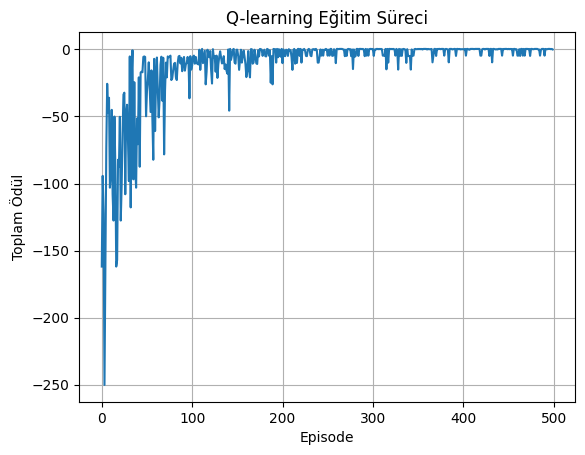

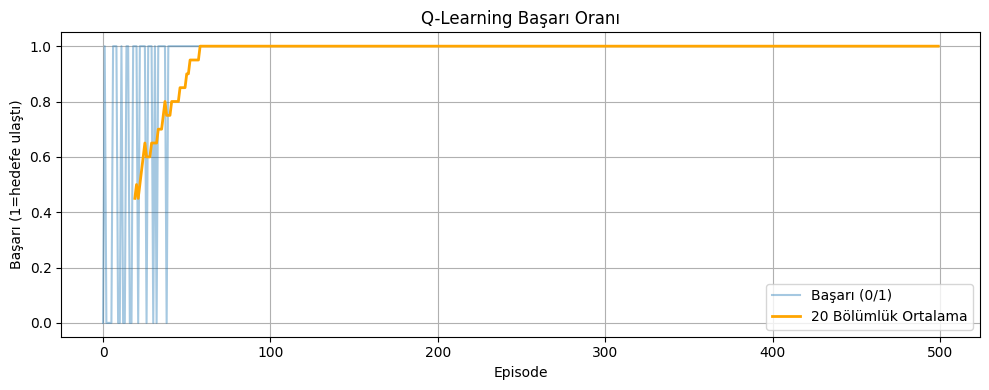

In [175]:
# Başarı oranı ve isimli GIF üretimi
success_rate = int(100 * sum(success_history) / episodes)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
gif_filename = f"maze_runner_{success_rate}p_{timestamp}.gif"
gif_path = os.path.join(output_dir, gif_filename)

# En iyi yolu bul ve GIF olarak kaydet
best_path = get_best_path(q_table, maze, start_pos, goal_pos, actions)
generate_gif_from_path(maze, best_path, gif_path)

# Eğitim süreci görselleştirme
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Toplam Ödül")
plt.title("Q-learning Eğitim Süreci")
plt.grid(True)
plt.show()

plot_success_rate(success_history)


In [137]:
#Q-learning eğitim döngüsü
for episode in range(episodes):
    state = start_pos
    total_reward = 0
    reached_goal = 0

    for step in range(max_steps):
        i, j = state
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0 ,3)
        else:
            action = np.argmax(q_table[i][j])

        move = actions[action]
        new_state = (i + move[0], j + move[1])

        if not is_valid_move(maze, new_state):
            reward = -5
            new_state = state
        elif new_state == goal_pos:
            reward = 100
        else:
            reward = -1

        ni, nj = new_state
        q_table[i][j][action] += alpha * (
            reward + gamma * np.max(q_table[ni][nj]) - q_table[i][j][action]
        )

        state = new_state
        total_reward += reward

        if state == goal_pos:
            reached_goal = 1
            break

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards_per_episode.append(total_reward)
    success_history.append(reached_goal)